# Number of Upwelling Events and Extremes

#### Number of Upwelling Events (UI<sub>Ek</sub>, UI<sub>Ek<sub>alt</sub></sub>  and UI<sub>SST</sub>)
* define appropriate thresholds
    * found 100 m<sup>3</sup>/s km for UI<sub>Ek</sub> in lit
    * UI<sub>SST</sub> > 2°C (Joaquim)

#### Find extremes (UI<sub>Ek</sub>, UI<sub>SST</sub> and UI<sub>SSH</sub>)
* Find the top and bottom 10% of SUMMER upwelling weeks
    * do this for each UI and compare which weeks I get
    * for UI<sub>Ek</sub> top and bottom 10% plot the mean SLP during those weeks

In [4]:
## save figures
save_var = False

## Import packages and data

In [19]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.dates as dates
#import matplotlib
import cartopy.crs as ccrs
import os
import my_functions
from scipy.stats import linregress
#from scipy.stats import pearsonr
%matplotlib inline

In [5]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
SLP = xr.open_dataset('SLP_weekly.nc')
Angles = xr.open_dataset('Angles_coast.nc')
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [6]:
## set dir where I want to save my figures
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Iberian_Coast_Upwelling/Figures/Round II/')

## Data Prep

In [7]:
## selct common period MTSS, SLP and SST
MTSS = MTSS.sel(time = slice('01/01/1982', '31/12/2022'))
SLP = SLP.sel(time = slice('01/01/1982', '31/12/2022'))
SST = SST.sel(time = slice('01/01/1982', '31/12/2022'))

In [9]:
## calculate the UIs (and add mid_shelf mask)
# UI Ek
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm),
                                      near_shore = True, angles = Angles.angle_phi)
Ek = my_functions.add_mid_shelf(Ek, mid_shelf_lat, mid_shelf_lon)

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [10]:
## meridional mean
Ek = my_functions.calc_meridional_mean(Ek, lon = -10.5)
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103)
SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

In [11]:
## summer subset
Ek_summer = my_functions.subset_summer(Ek)
SLP_summer = my_functions.subset_summer(SLP)
SST_summer = my_functions.subset_summer(SST)
SSH_summer = my_functions.subset_summer(SSH)

## Functions

In [46]:
def plot_extreme_occurence(Ek, SST, SSH, sub_start = 0, sub_stop = 0.1, title = 'Top 10% of upwelling weeks', variables = False, save = False, save_fig_as = 'Extremes'):

    # order and do subselection (based on percentage of values) [subset desired values]
    # it odrders my array and starts with the highest values -› index 0 is highest
    Ek_sub = Ek.time.sortby(Ek.UI_mean, ascending = False).values[round(Ek.time.shape[0] * sub_start) : round(Ek.time.shape[0] * sub_stop)]
    SST_sub = SST.time.sortby(SST.UI_mean, ascending = False).values[round(SST.time.shape[0] * sub_start) : round(SST.time.shape[0] * sub_stop)]
    SSH_sub = SSH.time.sortby(SSH.UI_mean, ascending = False).values[round(SSH.time.shape[0] * sub_start) : round(SSH.time.shape[0] * sub_stop)]
    
    fig = plt.figure(figsize = (15,1.2))
    plt.scatter(Ek.time.sel(time = Ek_sub), np.zeros(len(Ek_sub))+1, marker = "|", s = 300, color = 'darkcyan', alpha = 0.4, label = r'$UI_{Ek}$')
    plt.scatter(SST.time.sel(time = SST_sub), np.zeros(len(SST_sub))+0.5, marker = "|",  s = 300, color = 'rebeccapurple', alpha = 0.4, label = r'$UI_{SST}$')
    plt.scatter(SSH.time.sel(time = SSH_sub), np.zeros(len(SSH_sub)), marker = "|",  s = 300, color = 'darkgreen', alpha = 0.4, label = r'$UI_{SSH}$')
    plt.yticks([])
    plt.ylim(-0.3,1.3)
    plt.grid()
    plt.legend(bbox_to_anchor=(1, 1.1), labelspacing = 1.2, loc = 'upper left', edgecolor = 'none', facecolor = 'none'),
    plt.title(title)

    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')
        
    if variables:
        return Ek_sub, SST_sub, SSH_sub
    
        

In [28]:
## plot map

def plot_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label', add_contour = False, save =  save_var, save_fig_as = 'Map'):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
      
    cp = DS.plot(add_colorbar = False, cmap = cmap, vmin = vmin, vmax = vmax, alpha = 0.8)
    plt.colorbar(cp, ax = ax, label = cbar_label, fraction = 0.046, pad = 0.01);

    if add_contour == True:
        clp = DS.plot.contour(colors = 'black', linewidths = 1, levels = np.arange(1010,1028, 0.25))
        plt.clabel(clp, fontsize = 7)
    
    plt.title(f'{title}')

    if save:
        plt.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

In [68]:
## number of events

def plot_events(DS, color, title, save = False, save_fig_as = 'Events'):
    fig = plt.figure(figsize = (12,4))
    
    years = DS.year
    time = np.arange(0, len(years))
    
    plt.bar(years, DS, color = color, alpha = 0.7)
    
    # calculate trend line full period
    regression = linregress(time, DS)  
    # calculate trend last decade
    regression_10 = linregress(time[-10:None], DS.isel(year = slice(-10,None)))
    # calculate trend decade before that
    regression_20 = linregress(time[-20:-10], DS.isel(year = slice(-20,-10)))
    
    plt.plot(years, regression.slope * time + regression.intercept, 'k', lw = 1, label = 'Trend');
    plt.plot(years[-10:None], regression_10.slope * time[-10:None] + regression_10.intercept, 'k:', label = 'Trend last decade');
    plt.plot(years[-20:-10], regression_20.slope * time[-20:-10] + regression_20.intercept, 'k--', lw = 1, label = "Trend 'second last' decade");

    # plot
    plt.title(title)
    plt.ylabel('Number of Events');
    plt.legend(bbox_to_anchor=(1.0, 1), loc = 'upper left', labelspacing = 6.2, edgecolor = 'none', facecolor = 'none')
    plt.grid(linewidth = 0.5)
    plt.yticks(np.arange(0,22,2));
    
    # stats
    ## UI_SST number of events whole period
    plt.figtext(0.91, 0.69, r'  $R^2$:' f'{(regression.rvalue**2):.5f} \n  Trend: {regression.slope:.5f} \n  p-value: {regression.pvalue:.5f}')
    plt.figtext(0.91, 0.44, r'  $R^2$:' f'{(regression_10.rvalue**2):.5f} \n  Trend: {regression_10.slope:.5f} \n  p-value: {regression_10.pvalue:.5f}')
    plt.figtext(0.91, 0.19, r'  $R^2$:' f'{(regression_20.rvalue**2):.5f} \n  Trend: {regression_20.slope:.5f} \n  p-value: {regression_20.pvalue:.5f}')

    if save:
        plt.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches='tight')

## Number of Upwelling Events

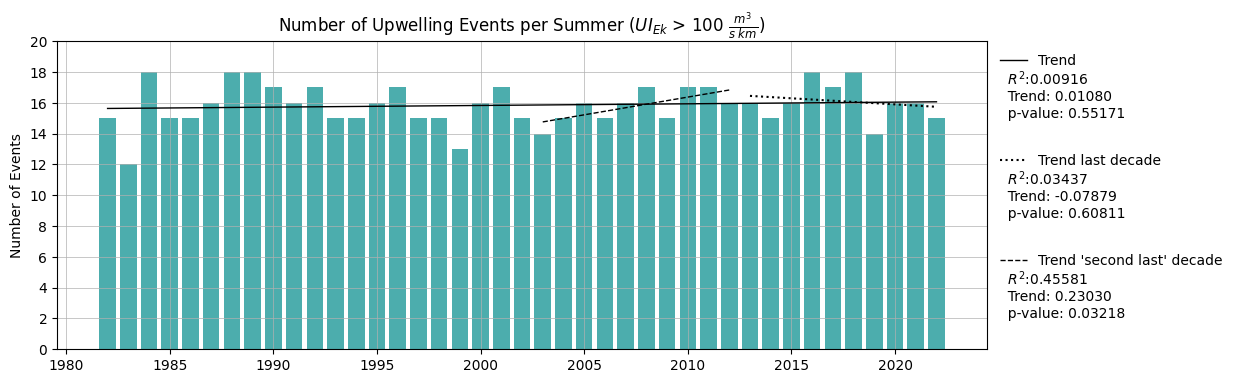

In [76]:
# number of upwelling events UI Ek -> defined as UI_Ek > 100 m3/s km -> 0.1 m3/s m
Ek_summer_event = Ek_summer.UI_mean.where(Ek_summer.UI_mean > 0.1).groupby('time.year').count(dim = 'time')
plot_events(Ek_summer_event, color = 'darkcyan', title = r'Number of Upwelling Events per Summer ($UI_{Ek}$ > 100 $\frac{m^3}{s \ km}$)')

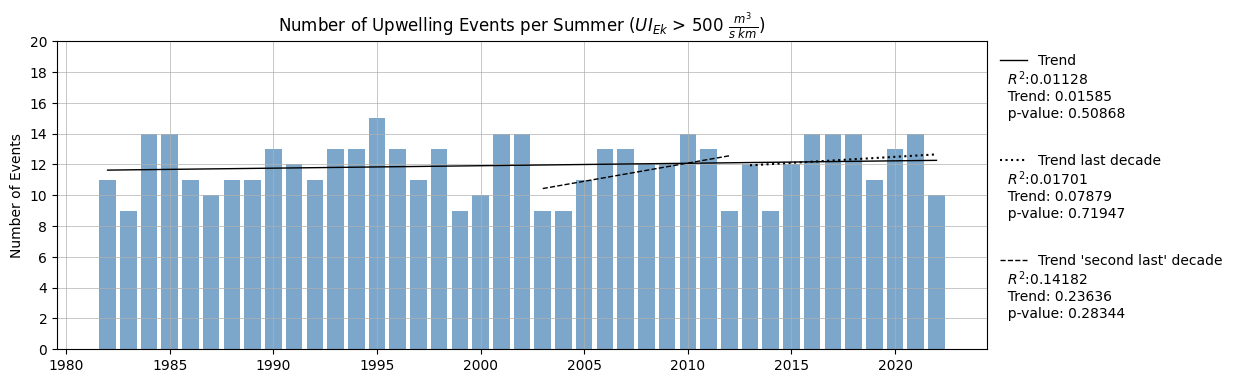

In [75]:
# number of upwelling events UI Ek -> defined as UI_Ek > 500 m3/s km -> 0.5 m3/s m
Ek_summer_event = Ek_summer.UI_mean.where(Ek_summer.UI_mean > 0.5).groupby('time.year').count(dim = 'time')
plot_events(Ek_summer_event, color = 'steelblue', title = r'Number of Upwelling Events per Summer ($UI_{Ek}$ > 500 $\frac{m^3}{s \ km}$)')

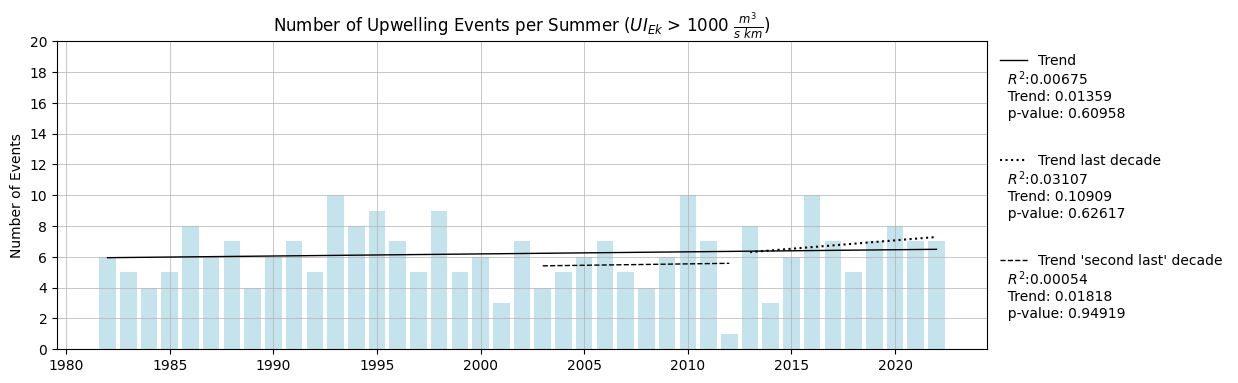

In [77]:
# number of upwelling events UI Ek -> defined as UI_Ek > 1000 m3/s km -> 1 m3/s m
Ek_summer_event = Ek_summer.UI_mean.where(Ek_summer.UI_mean > 1).groupby('time.year').count(dim = 'time')
plot_events(Ek_summer_event, color = 'lightblue', title = r'Number of Upwelling Events per Summer ($UI_{Ek}$ > 1000 $\frac{m^3}{s \ km}$)')

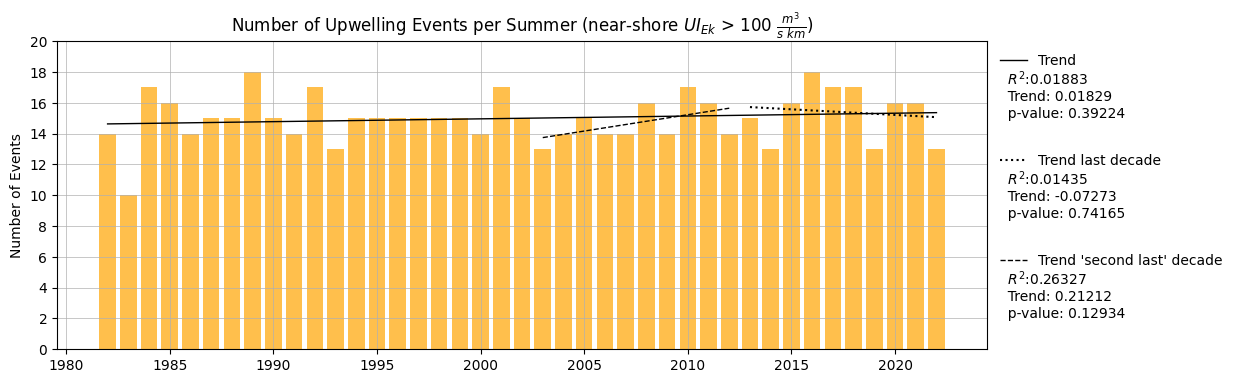

In [98]:
# number of upwelling events ALTERNATIVE UI Ek -> defined as UI_Ek > 100 m3/s km -> 0.1 m3/s m
Ek_ns_summer_mean = Ek_summer.UI_ns.mean(dim = ['lat', 'lon'])
Ek_ns_summer_event = Ek_ns_summer_mean.where(Ek_ns_summer_mean > 0.1).groupby('time.year').count(dim = 'time')
plot_events(Ek_ns_summer_event, color = 'orange', title = r'Number of Upwelling Events per Summer (near-shore $UI_{Ek}$ > 100 $\frac{m^3}{s \ km}$)')


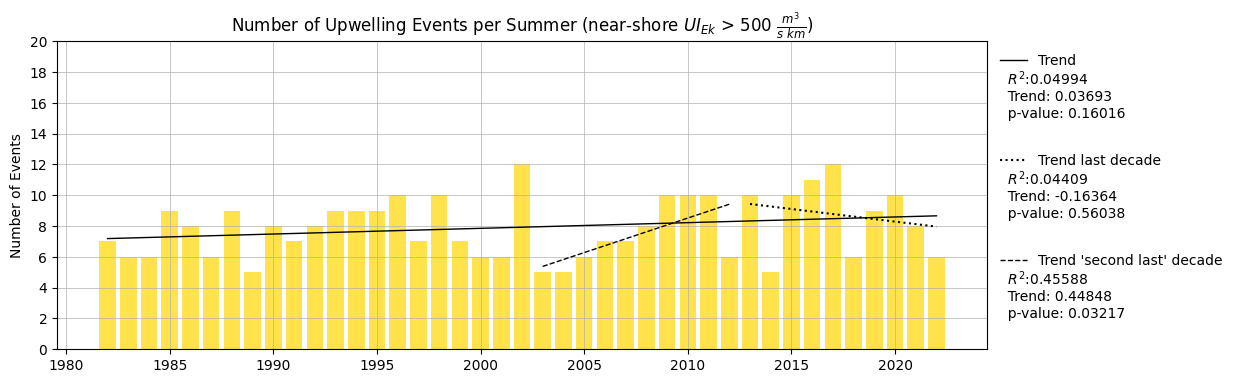

In [103]:
# number of upwelling events ALTERNATIVE UI Ek -> defined as UI_Ek > 500 m3/s km -> 0.5 m3/s m
Ek_ns_summer_event = Ek_ns_summer_mean.where(Ek_ns_summer_mean > 0.5).groupby('time.year').count(dim = 'time')
plot_events(Ek_ns_summer_event, color = 'gold', title = r'Number of Upwelling Events per Summer (near-shore $UI_{Ek}$ > 500 $\frac{m^3}{s \ km}$)')


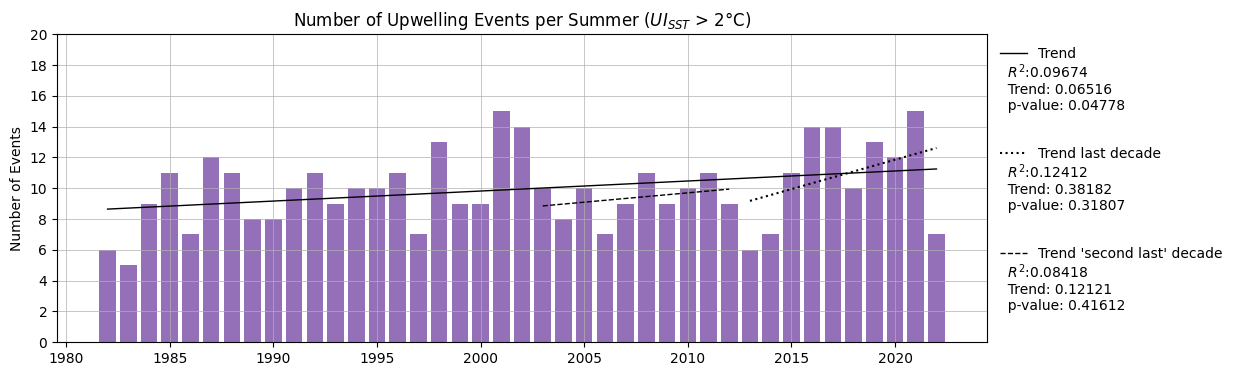

In [89]:
# number of upwelling events UI SST -> defined as UI_SST > 2°
SST_summer_event = SST_summer.UI_mean.where(SST_summer.UI_mean > 2).groupby('time.year').count(dim = 'time')
plot_events(SST_summer_event, color = 'rebeccapurple', title = 'Number of Upwelling Events per Summer ($UI_{SST}$ > 2°C)')

## Find Extreme Upwelling Weeks

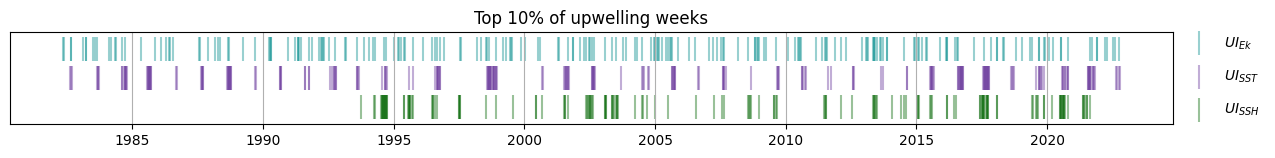

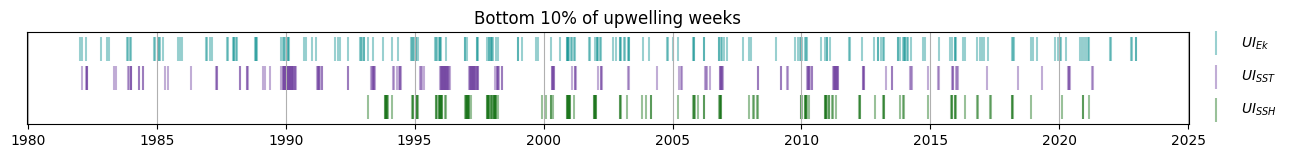

In [9]:
## Whole period
# top 10%
Ek_top_10, SST_top_10, SSH_top_10 = plot_extreme_occurence(Ek, SST, SSH, variables = True) # by default does to 10% 
# bottom 10% 
Ek_bottom_10, SST_bottom_10, SSH_bottom_10 = plot_extreme_occurence(Ek, SST, SSH, sub_start = 0.9, sub_stop = 1, title = 'Bottom 10% of upwelling weeks', variables = True) 

In [10]:
np.where(Ek_top_10 == SST_top_10)[0] # there is just noo overlap... apparently (maybe I need to check one week delayed)

array([], dtype=int64)

In [11]:
# delay Ek 
np.where(Ek_top_10 + np.timedelta64(7, 'D') == SST_top_10)[0]

array([], dtype=int64)

In [12]:
np.where(Ek_bottom_10 == SST_bottom_10)[0] 

array([], dtype=int64)

In [13]:
# delay Ek ... no matter what I try I get nothing
np.where(Ek_bottom_10 + np.timedelta64(14, 'D') == SST_bottom_10)[0]

array([ 51, 173])

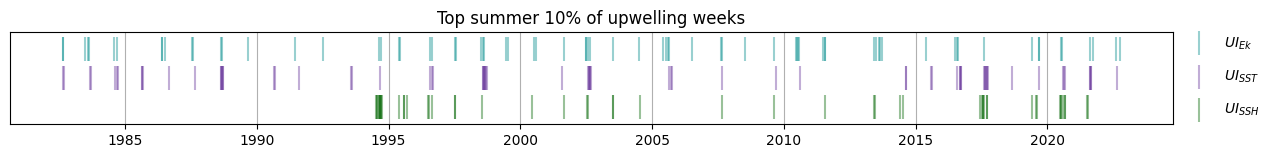

In [47]:
## Summer
Ek_sub_summer, SST_sub_summer, SSH_sub_summer = plot_extreme_occurence(Ek_summer, SST_summer, SSH_summer, title = 'Top summer 10% of upwelling weeks', variables = True, save =  save_var, save_fig_as = 'Extreme_summer_all_UIs') # by default does to 10% 

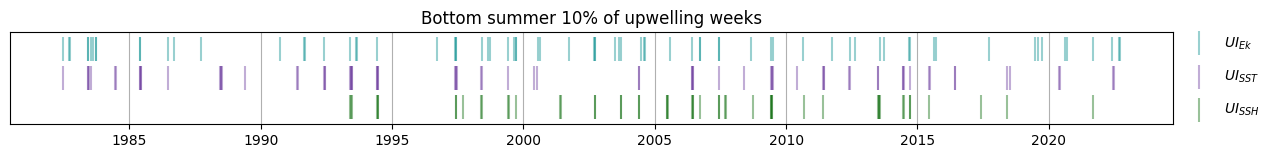

In [43]:
# bottom 10% 
plot_extreme_occurence(Ek_summer, SST_summer, SSH_summer, sub_start = 0.9, sub_stop = 1, title = 'Bottom summer 10% of upwelling weeks',
                      save =  save_var, save_fig_as = 'Bla') 

In [16]:
Ek_sub_summer + np.timedelta64(-7, 'D') == SST_sub_summer # same as above

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [45]:
Ek_sub_summer

array(['2010-06-15T00:00:00.000000000', '2007-08-21T00:00:00.000000000',
       '1988-09-13T00:00:00.000000000', '2005-07-05T00:00:00.000000000',
       '1984-08-07T00:00:00.000000000', '1986-06-03T00:00:00.000000000',
       '2017-08-08T00:00:00.000000000', '1986-05-27T00:00:00.000000000',
       '2000-07-11T00:00:00.000000000', '2013-08-27T00:00:00.000000000',
       '2013-06-25T00:00:00.000000000', '2016-07-26T00:00:00.000000000',
       '2010-08-03T00:00:00.000000000', '2002-06-25T00:00:00.000000000',
       '2019-09-03T00:00:00.000000000', '2016-06-28T00:00:00.000000000',
       '2011-07-26T00:00:00.000000000', '1995-06-06T00:00:00.000000000',
       '2011-07-19T00:00:00.000000000', '2020-07-07T00:00:00.000000000',
       '1987-07-28T00:00:00.000000000', '2020-07-14T00:00:00.000000000',
       '2005-05-31T00:00:00.000000000', '1992-07-07T00:00:00.000000000',
       '1995-05-30T00:00:00.000000000', '2015-05-26T00:00:00.000000000',
       '2000-08-01T00:00:00.000000000', '1998-07-28

## Plot SLP 
- mean summer SLP
- mean SLP during top and bottom 10% of UI<sub>Ek</sub>

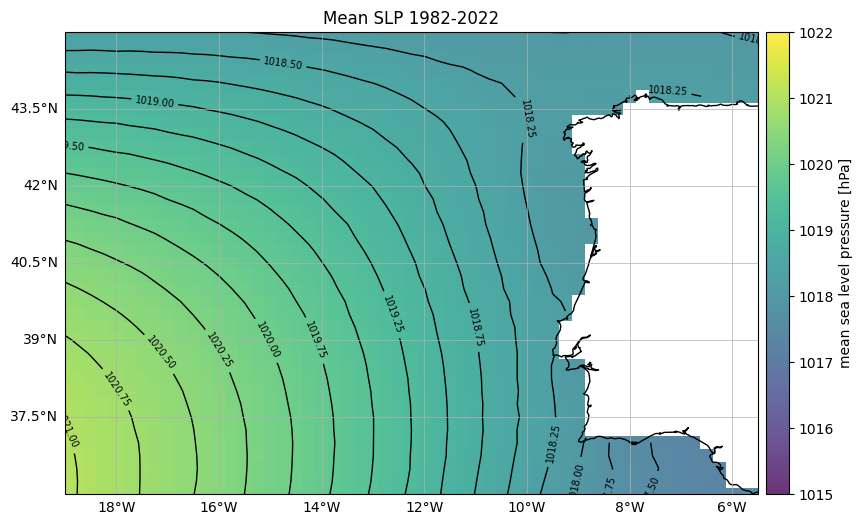

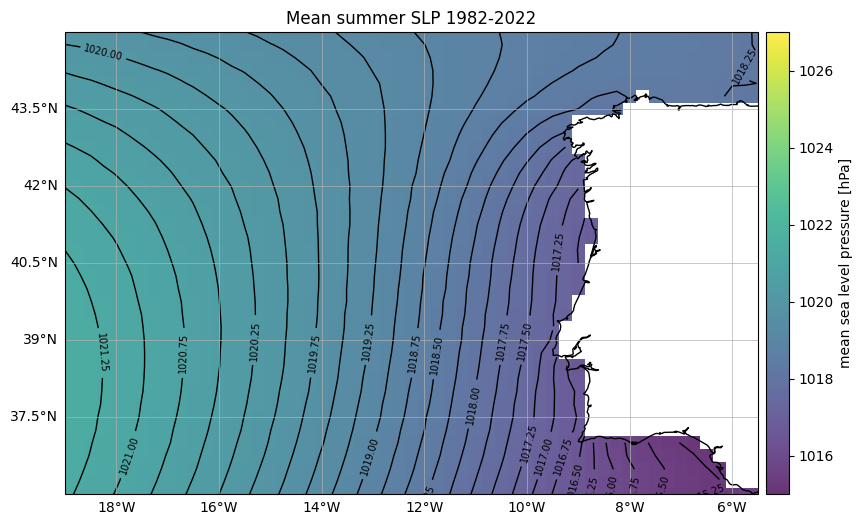

In [48]:
plot_map(SLP.msl.where(SLP.lsm).mean(dim = 'time') * 0.01, title = 'Mean SLP 1982-2022', cmap = 'viridis', 
         vmin = 1015, vmax = 1022, cbar_label = 'mean sea level pressure [hPa]', add_contour = True)
plot_map(SLP_summer.msl.where(SLP.lsm).mean(dim = 'time') * 0.01, title = 'Mean summer SLP 1982-2022', cmap = 'viridis', 
         vmin = 1015, vmax = 1022, cbar_label = 'mean sea level pressure [hPa]', add_contour = True,
         save = False, save_fig_as = 'Map_summer_mean_SLP')
# in summer the high pressure system is slightly further north

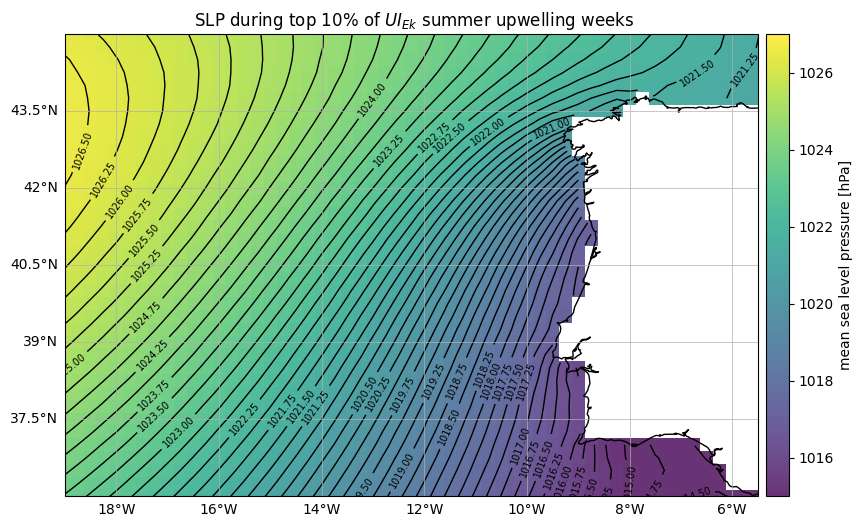

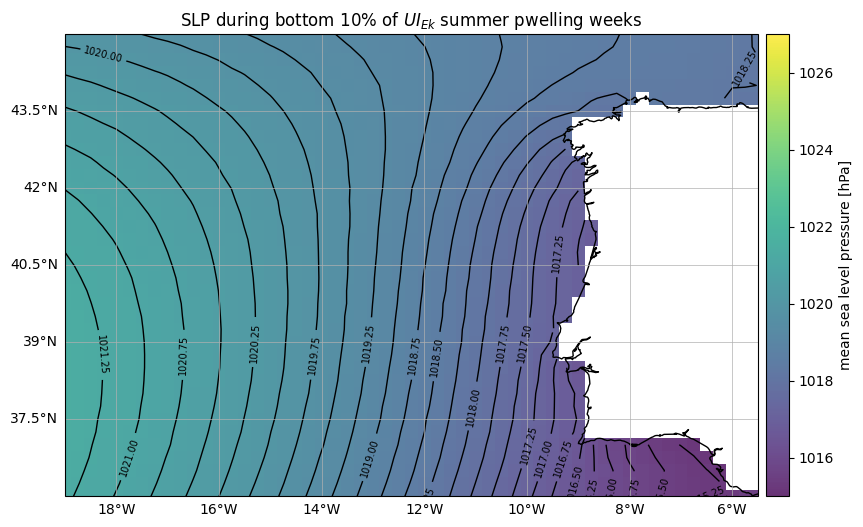

In [33]:
Ek_top_10_summer = Ek_summer.time.sortby(Ek_summer.UI_mean, ascending = False).values[round(Ek_summer.time.shape[0] * 0) : round(Ek_summer.time.shape[0] * 0.1)]
SLP_top_10_summer = SLP_summer.sel(time = Ek_top_10_summer)
plot_map(SLP_top_10_summer.msl.where(SLP.lsm).mean(dim = 'time') * 0.01, title =' SLP during top 10% of $UI_{Ek}$ summer upwelling weeks', cmap = 'viridis', 
         vmin = 1015, vmax = 1027, cbar_label = 'mean sea level pressure [hPa]', add_contour = True, 
         save =  save_var, save_fig_as = 'Map_SLP_during_top_10_UI_Ek_summer_upwelling')

Ek_bottom_10_summer = Ek_summer.time.sortby(Ek_summer.UI_mean, ascending = False).values[round(Ek_summer.time.shape[0] * 0.9) : round(Ek_summer.time.shape[0] * 1)]
SLP_bottom_10_summer = SLP_summer.sel(time = Ek_bottom_10_summer)
plot_map(SLP_summer.msl.where(SLP.lsm).mean(dim = 'time') * 0.01, title = 'SLP during bottom 10% of $UI_{Ek}$ summer pwelling weeks', cmap = 'viridis', 
         vmin = 1015, vmax = 1027, cbar_label = 'mean sea level pressure [hPa]', add_contour = True,
         save =  save_var, save_fig_as = 'Map_SLP_during_bottom_10_UI_Ek_summer_upwelling')